In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


test_data = pd.read_csv("data/test.csv")
train_data = pd.read_csv("data/train.csv")
# print(train_data.head())
# print(train_data['SalePrice'])

In [2]:
#Removing rows without sale price
train_data.dropna(axis=0, subset=['SalePrice'], inplace = True)

#Our target
y = train_data.SalePrice

train_data.drop(['SalePrice'],axis=1, inplace =True)


In [3]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(train_data, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)


In [4]:

numeric_col = [col_name for col_name in X_train_full.columns 
               if X_train_full[col_name].dtype in ['int64', 'float64']] 
# print(numeric_col)

categ_col = [col_name for col_name in X_train_full.columns 
               if X_train_full[col_name].dtype == 'object'
            and X_train_full[col_name].nunique() <10]
# print(categ_col)

In [7]:
staying_col = numeric_col + categ_col
other = set(train_data.columns) - set(staying_col)
print(other)
#Removing columns that are categorical and have more than 10 unique categorical values
X_train = X_train_full[staying_col].copy()
X_valid = X_valid_full[staying_col].copy()
X_test = test_data[staying_col].copy()


{'Exterior1st', 'Neighborhood', 'Exterior2nd'}


In [44]:
X_train.tail()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
763,764,60,82.0,9430,8,5,1999,1999,673.0,1163,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
835,836,20,60.0,9600,4,7,1950,1995,0.0,442,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1216,1217,90,68.0,8930,6,5,1978,1978,0.0,0,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
559,560,120,NaN,3196,7,5,2003,2004,18.0,0,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
684,685,60,58.0,16770,7,5,1998,1998,30.0,0,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [6]:

#Creating pipeline

numerical_transformer =SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_col),
        ('cat', categorical_transformer, categ_col)
    ])

model = RandomForestRegressor(n_estimators=200, random_state=0)


In [35]:

li = [ i*50 for i in range(9) if i>0]

print(li)
results ={} 

for i in li:
    model = RandomForestRegressor(n_estimators=i, random_state=0)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)
                                 ])

    pipeline.fit(X_train, y_train)

    preds = pipeline.predict(X_valid)

    score = mean_squared_error(y_valid, preds)
    
    results[i] = score
print('MSE:', score)

[50, 100, 150, 200, 250, 300, 350, 400]
MSE: 1155480419.6345558


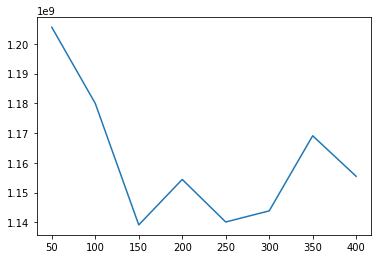

In [48]:
# Plotting score as function of n_estimators
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results.keys(), results.values())
plt.show()

In [47]:
model = RandomForestRegressor(n_estimators=150, random_state=0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)
                                 ])

pipeline.fit(X_train, y_train)


#Generating predictions from test set  1179973008.4162304 - meadian
#                                      1201338805  - mean
#                                      1060922040.6537697
preds_test = pipeline.predict(X_test) 

output = pd.DataFrame({'Id': X_test.index+1461,
                       'SalePrice': preds_test})
output.to_csv('prices_n150.csv', index=False)